In [19]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use("figures.mplstyle")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
forward_flux_files = {
    "LHC13":{
        "light":["DPMJET", "EPOSLHC", "PYTHIA8", "QGSJET", "SIBYLL"],
        "charm":["BDGJKR", "BKRS", "BKSS", "MS", "SIBYLL"]
    },
    "Large":{
        "light":["EPOSLHC"],
        "charm":["BKRS"]
    },
    "Run3":{
        "light":["EPOSLHC"],
        "charm":["POWHEG+P8monash"]
    },
    "VLarge":{
        "light":["EPOSLHC","SIBYLL"],
        "charm":["BKRS"]
    }
}
primaries = [12,-12,
             14,-14,
             16,-16
            ]
detectors=["SINE_CMS_West",
           "UNDINE_CMS_East"]
data = {}
for detector in detectors:
    for prefix,parent_dict in forward_flux_files.items():
        if prefix!="LHC13": continue
        for parent,generators in parent_dict.items():
            for generator in generators:
                for primary in primaries:
                    if "SINE" in detector and abs(primary)!=14: continue
                    if parent=="light" and abs(primary)==16: continue
                    key = tuple((detector,prefix,generator,parent,primary))
                    print(key)
                    siren_output_file = "Data/SIREN/Output/%s/%s_%s_%s_%s"%(detector,prefix,generator,parent,primary)
                    try:
                        data[key] = ak.from_parquet(siren_output_file+".parquet")
                    except:
                        print("Couldn't open %s"%siren_output_file)
                

('SINE_CMS_West', 'LHC13', 'DPMJET', 'light', 14)
('SINE_CMS_West', 'LHC13', 'DPMJET', 'light', -14)
('SINE_CMS_West', 'LHC13', 'EPOSLHC', 'light', 14)
('SINE_CMS_West', 'LHC13', 'EPOSLHC', 'light', -14)
('SINE_CMS_West', 'LHC13', 'PYTHIA8', 'light', 14)
('SINE_CMS_West', 'LHC13', 'PYTHIA8', 'light', -14)
('SINE_CMS_West', 'LHC13', 'QGSJET', 'light', 14)
('SINE_CMS_West', 'LHC13', 'QGSJET', 'light', -14)
('SINE_CMS_West', 'LHC13', 'SIBYLL', 'light', 14)
('SINE_CMS_West', 'LHC13', 'SIBYLL', 'light', -14)
('SINE_CMS_West', 'LHC13', 'BDGJKR', 'charm', 14)
('SINE_CMS_West', 'LHC13', 'BDGJKR', 'charm', -14)
('SINE_CMS_West', 'LHC13', 'BKRS', 'charm', 14)
('SINE_CMS_West', 'LHC13', 'BKRS', 'charm', -14)
('SINE_CMS_West', 'LHC13', 'BKSS', 'charm', 14)
('SINE_CMS_West', 'LHC13', 'BKSS', 'charm', -14)
('SINE_CMS_West', 'LHC13', 'MS', 'charm', 14)
('SINE_CMS_West', 'LHC13', 'MS', 'charm', -14)
('SINE_CMS_West', 'LHC13', 'SIBYLL', 'charm', 14)
('SINE_CMS_West', 'LHC13', 'SIBYLL', 'charm', -14)
('

# paper figures from SIREN

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS
EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


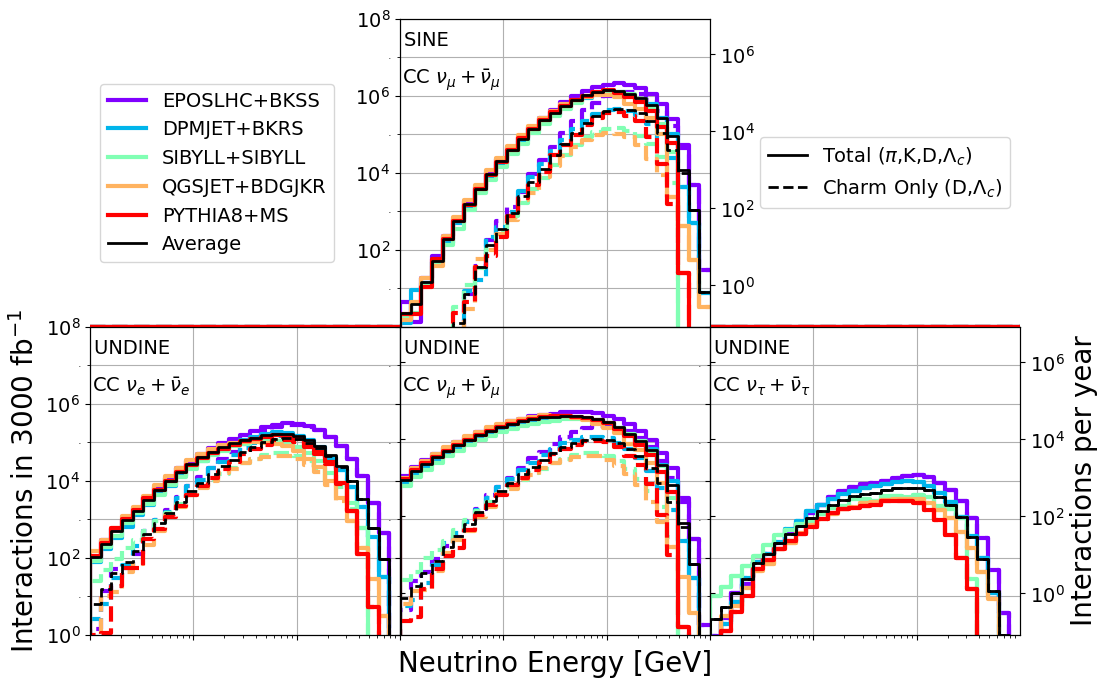

In [30]:
prefix = "LHC13"
num_UNDINE = 5
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]


fig,ax = plt.subplots(2,3,figsize=(12,8))
fig.set_facecolor("white")

twin_ax = np.empty_like(ax)
for i in range(2):
    for j in range(3):
        twin_ax[i,j] = ax[i,j].twinx()
        

fig.subplots_adjust(wspace=0, hspace=0)
ax[0,0].axis("off")
ax[0,2].axis("off")
twin_ax[0,0].axis("off")
twin_ax[0,2].axis("off")

Ebins = np.logspace(1,4,30)
pids = [12,14,16]

yearly_factor = 250./3000. # 250 fb^-1 per year / 3 ab^-1 total

total_rates = {}

for i,det in enumerate(detectors):
        
    Ehist_l_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    Ehist_c_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    Ehist_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
    
    color = iter(cm.rainbow(np.linspace(0, 1, len(light_generators))))

    for lg,cg in zip(light_generators,charm_generators):

        c = next(color)
        print(lg,cg)
    
        lkey = tuple((det,prefix,lg,"light"))
        ckey = tuple((det,prefix,cg,"charm"))

        

        for iax,pid in enumerate(pids):

            
            
            if pid!=16 and not (pid!=14 and "SINE" in det):
                ldata = ak.concatenate([data[lkey+(pid,)],data[lkey+(-pid,)]])
                weights = np.array(ldata.weights)
                if "SINE" in det: weights *= np.array(ldata.hit_mask_muon_survival)
                if "UNDINE" in det: weights *= num_UNDINE*np.array(ldata.in_fiducial)[:,-1]
                #vx = np.squeeze(ldata.vertex)
                Ehist_l,_ = np.histogram(ldata.energy,bins=Ebins,weights=weights)
            else:
                Ehist_l = np.zeros(len(Ebins)-1)
            if not (pid!=14 and "SINE" in det):
                cdata = ak.concatenate([data[ckey+(pid,)],data[ckey+(-pid,)]])
                weights = np.array(cdata.weights)
                if "SINE" in det: weights *= np.array(cdata.hit_mask_muon_survival)
                if "UNDINE" in det: weights *= num_UNDINE*np.array(cdata.in_fiducial)[:,-1]
                #vx = np.squeeze(cdata.vertex)
                Ehist_c,_ = np.histogram(cdata.energy,bins=Ebins,weights=weights)
            else:
                Ehist_c = np.zeros(len(Ebins)-1)


            Ehist = np.array(Ehist_l+Ehist_c)
            Ehist_avg[pid] += Ehist/len(light_generators)
            Ehist_l_avg[pid] += np.array(Ehist_l)/len(light_generators)
            Ehist_c_avg[pid] += np.array(Ehist_c)/len(charm_generators)
            ax[i,iax].step(Ebins,np.append([0],Ehist),color=c,label="%s+%s"%(lg,cg) if i==0 and iax==0 else None,lw=3)
            ax[i,iax].step(Ebins,np.append([0],Ehist_c),color=c,ls="--",lw=3)
    
    for iax,pid in enumerate(pids):
        total_rates[tuple((det,"light",pid))] = sum(Ehist_l_avg[pid])
        total_rates[tuple((det,"charm",pid))] = sum(Ehist_c_avg[pid])    
        if not(i==0 and iax!=1):
            ax[i,iax].step(Ebins,np.append([0],Ehist_c_avg[pid]),color="black",ls="--")
            ax[i,iax].step(Ebins,np.append([0],Ehist_avg[pid]),color="black")
        elif i==0 and iax==0:
             ax[i,iax].plot([],[],label="Average",color="black")
            
ax[1,1].set_xlabel("Neutrino Energy [GeV]",fontsize=20)
ax[1,0].set_ylabel(r"Interactions in $3000~{\rm fb}^{-1}$",fontsize=20)
twin_ax[1,2].set_ylabel(r"Interactions per year",fontsize=20)
ax[0,2].plot([],[],color="black",label=r"Total ($\pi$,K,D,$\Lambda_c$)")
#ax[0,2].plot([],[],color="black",ls='--',label=r"$\pi$,K")
ax[0,2].plot([],[],color="black",ls='--',label=r"Charm Only (D,$\Lambda_c$)")
ax[0,0].legend(loc="center left",fontsize=14)
ax[0,2].legend(loc="center right",fontsize=14)

det_labels = ["SINE CC","UNDINE CC", "UNDINE NC"]
particle_labels = [r"$\nu_e+\bar{\nu}_e$",
                   r"$\nu_\mu+\bar{\nu}_\mu$",
                   r"$\nu_\tau+\bar{\nu}_\tau$"]
for i in [0,1]:
    for j in [0,1,2]:
            
        ax[i,j].set_xlim(1e1,Ebins[-1])
        ax[i,j].set_ylim(1e0,1e8)
        ax[i,j].set_xlim(1e1,1e4)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=0)
        twin_ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].get_xaxis().grid(True,which='major')
        ax[i,j].get_yaxis().grid(True,which='both')
        
        if not(i==0 and j in [0,2]):
            ax[i,j].text(11,2e7,det_labels[i][:-2],fontsize=14)
            ax[i,j].text(10.5,2e6,det_labels[i][-2:]+" "+ particle_labels[j],fontsize=14)
            ax[i,j].loglog()
            mn, mx = ax[i,j].get_ylim()
            twin_ax[i,j].set_ylim(mn*yearly_factor, mx*yearly_factor)
            twin_ax[i,j].loglog()
        
        # xticks
        if i!=2: 
            ax[i,j].set_xticklabels([])
        if i!= 0: 
            ax[i,j].set_xticks(np.logspace(1,3,3))
        
        # yticks
        if i==0 and j==1:
            ax[i,j].set_yticks(np.logspace(2,8,4))
            ax[i,j].set_yticks(np.logspace(1,8,8),minor=True)
        elif i==1 and j==0:
            ax[i,j].set_yticks(np.logspace(0,8,5))
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
        elif i==2 and j==0:
            ax[i,j].set_yticks(np.logspace(0,6,4))
            ax[i,j].set_yticks(np.logspace(0,7,8),minor=True)
        else:
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
            ax[i,j].set_yticklabels([])
        
        if (i==0 and j==1) or (j==2 and i in [1,2]):
            twin_ax[i,j].set_yticks(np.logspace(0,6,4))
        else:
            twin_ax[i,j].set_yticklabels([])

plt.savefig("Figures/SIREN/Distributions.pdf",dpi=100)
plt.show()
            

In [46]:
for detector in detectors:
    for pid,pid_label in zip(pids,particle_labels):
        if pid!=14 and "SINE" in detector: continue
        rate_light = total_rates[tuple((detector,"light",pid))]
        rate_charm = total_rates[tuple((detector,"charm",pid))]
        
        print("%s (%s CC) & %s & %s & %s \\\\"%("SINE" if "SINE" in detector else "UNDINE",
                                           pid_label,
                                           "$10^{%1.2f}$"%np.log10(rate_light+rate_charm),
                                           "$10^{%1.2f}$"%np.log10(rate_light) if rate_light > 0 else "0",
                                           "$10^{%1.2f}$"%np.log10(rate_charm)))
              
              

SINE ($\nu_\mu+\bar{\nu}_\mu$ CC) & $10^{7.00}$ & $10^{6.87}$ & $10^{6.44}$ \\
UNDINE ($\nu_e+\bar{\nu}_e$ CC) & $10^{6.17}$ & $10^{5.73}$ & $10^{5.97}$ \\
UNDINE ($\nu_\mu+\bar{\nu}_\mu$ CC) & $10^{6.75}$ & $10^{6.68}$ & $10^{5.96}$ \\
UNDINE ($\nu_\tau+\bar{\nu}_\tau$ CC) & $10^{4.79}$ & 0 & $10^{4.79}$ \\


# Charm production model sensitivity